C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


count    256.000000
mean       1.144531
std        0.637558
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        9.000000
Name: medication_frequency, dtype: float64

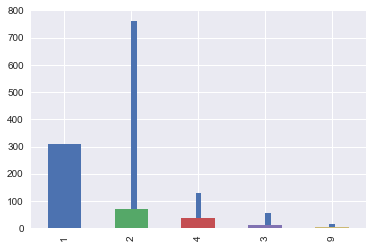

In [2]:
"""
Created on 01/22/2019
Latest modified on 11/19/2018
@author: Gen Zhu gen.zhu@uth.tmc.edu

Purpose: this program is to analyze the total consumed strength of dose
         of the patients who receive only one type of treatments.

Input files:
           1. sah_pts_enc_med_sl_ad_cl2.tsv (created by Laila on 07/31/2018)
           2. sah_pts_all_enc_med_cl3.tsv (created by Laila on 08/01/2018)
           3. PAT_file_ENC.csv (created by Vahed on 11/02/2018)
           4. SAH_ENC_screened_24h_rule.csv (created by Vahed on 11/02/2018)
           5. Diastolic_BP(created by Helen on 07/03/2018)
"""
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
sns.set()
from matplotlib.dates import DateFormatter

def total_seconds(time):
    '''
    Convert the resolution of time to seconds
    '''
    return time.total_seconds()
# -----------------------------------------------------------------------------------
# Load the patient level table
# -----------------------------------------------------------------------------------
root_direc = 'H:Research/Hand_dirty/SAH_data/'
patient = pd.read_csv(
        root_direc+"/patient_encounter/Pat_file_ENC.csv")
patient['PATIENT_SK'].nunique()                      # 4810
SAH_ENC_screened_24h_rule = pd.read_csv(
  root_direc+"/patient_encounter/SAH_ENC_screened_24h_rule.csv")
SAH_ENC_screened_24h_rule['PATIENT_SK'].nunique()    # 4810
SAH_ENC_screened_24h_rule['ENCOUNTER_ID'].nunique()  # 4823
SAH_ENC_screened_24h_rule.shape
# Get a new patient level table by adding information such as encounter ID
pat_enc_final = pd.merge(patient, SAH_ENC_screened_24h_rule, on='PATIENT_SK')
pat_enc_final.shape

# -----------------------------------------------------------------------------------
# Prepare the medication table
# -----------------------------------------------------------------------------------

pd.options.display.max_rows = 200
enc_med_cl2 = pd.read_csv(
   root_direc+'/medication/sah_pts_enc_med_sl_ad_cl2.tsv', delimiter='\t')
enc_med_cl2['MED_STARTED_DT_TM'] = pd.to_datetime(
        enc_med_cl2['MED_STARTED_DT_TM'])
start_tm_na_ind = (enc_med_cl2['MED_STARTED_DT_TM'].apply(str)
                   == '01-JAN-1000 00:00:00')
stop_tm_na_ind = (enc_med_cl2['MED_STOPPED_DT_TM'].apply(str)
                  == '01-JAN-1000 00:00:00')
enc_med_cl2['MED_STOPPED_DT_TM'][stop_tm_na_ind] = np.nan
enc_med_cl2['MED_STOPPED_DT_TM'] = pd.to_datetime(
        enc_med_cl2['MED_STOPPED_DT_TM'])
enc_med_cl2['stop_start_gap'] = enc_med_cl2['MED_STOPPED_DT_TM'] -\
                 enc_med_cl2['MED_STARTED_DT_TM']
enc_med_cl2['stop_start_gap'] = enc_med_cl2['stop_start_gap'].\
                                apply(total_seconds)
enc_med_cl2['ENCOUNTER_ID'].nunique()  # 4881
enc_med_cl2['STRENGTH_UNITS'].value_counts(dropna=False)
enc_med_cl3 = pd.read_csv(
    root_direc+'/medication/sah_pts_all_enc_med_cl3.tsv', delimiter='\t')
# In order to get the dose quantity,
# we need to merge some columns between enc_med_cl2 and enc_med_cl3
enc_med_cl2 = pd.merge(enc_med_cl2,
                       enc_med_cl3[['INDEX_ID', 'DOSE_QUANTITY']],
                       on='INDEX_ID')
enc_med_cl2['UNIT_STRENGTH'] = enc_med_cl2.eval('ORDER_STRENGTH/DOSE_QUANTITY')
enc_med_cl2['TOTAL_CONSUMED_STRENGTH'] = enc_med_cl2.eval(
                                        'UNIT_STRENGTH *CONSUMED_QUANTITY')
enc_med_cl2['TOTAL_CONSUMED_STRENGTH'].describe()
# There is  inf and zero value of total_consumed_strength
sum((enc_med_cl2['TOTAL_CONSUMED_STRENGTH'] == np.inf)
    | (enc_med_cl2['TOTAL_CONSUMED_STRENGTH'] == 0))  # 90
# inf and zero value is resulted from value 0 of dose quantity and value
# 0 of order strength, so filter them and also filter NAs of order strength
enc_med_cl2_dropna = enc_med_cl2[(enc_med_cl2["ORDER_STRENGTH"] > 0)
                                 & (enc_med_cl2["DOSE_QUANTITY"] > 0)]
enc_med_cl2_dropna.shape  # (8066,32)


# -----------------------------------------------------------------------------------
# Combine the medication table with patient level table
# -----------------------------------------------------------------------------------

pat_enc_med = pd.merge(pat_enc_final[['PATIENT_SK', 'ENCOUNTER_ID']],
                       enc_med_cl2, on='ENCOUNTER_ID')
pat_enc_med['MED_STARTED_DT_TM'] = pd.to_datetime(
                                   pat_enc_med['MED_STARTED_DT_TM'])
pat_enc_med['MED_STOPPED_DT_TM'] = pd.to_datetime(
                                   pat_enc_med['MED_STOPPED_DT_TM'])
pat_enc_med = pat_enc_med.sort_values(by='MED_STARTED_DT_TM')
group_by_patientsk = pat_enc_med.groupby('PATIENT_SK')

# Get the number of types of treatments one patient received
treatment_types_per_patient = group_by_patientsk['GENERIC_NAME'].nunique()

# -----------------------------------------------------------------------------
# Analyze medication frequency for the patient who received only one type
# of treatments. Thereafter, we only care about the observations
# with valid values of total consumed strength, deleting the NAs
# or 0s of total consumed strength
# -----------------------------------------------------------------------------

# Extract the patients who only been assigned one type of treatment
one_type_treatment = pat_enc_med[pat_enc_med['PATIENT_SK'].isin(
       treatment_types_per_patient[treatment_types_per_patient == 1].index)]
# The number of patients who only been assigned one type of treatment
one_type_treatment.shape[0]  # 5813
one_type_treatment['PATIENT_SK'].nunique()  # 3293
one_type_treatment['TOTAL_CONSUMED_STRENGTH'].describe()
# First see how many observations whose total consumed strengths are available
one_type_treatment_valid_tcs = one_type_treatment.query(
      'TOTAL_CONSUMED_STRENGTH>0 & stop_start_gap>0')
# one_type_treatment_valid_tcs = one_type_treatment.query('stop_start_gap>0')
one_type_treatment_valid_tcs.shape[0]  # 3309
one_type_treatment_valid_tcs['PATIENT_SK'].nunique()  # 1839
# To calculate the frequency of the vasopressors for every patient
one_type_treatment_groupby_pat = one_type_treatment_valid_tcs.groupby(
        'PATIENT_SK')
one_type_treatment_vaspsr_counts = one_type_treatment_groupby_pat[
        'GENERIC_NAME'].value_counts()
# The distribution of the medication frequency
one_type_treatment_vaspsr_counts.hist(bins=100)
one_type_treatment_vaspsr_counts = one_type_treatment_vaspsr_counts.rename(
        "medication_frequency")
one_type_treatment_vaspsr_counts = one_type_treatment_vaspsr_counts\
                                  .reset_index()
# The distribution of the three types of treatments
one_type_treatment_vaspsr_counts['GENERIC_NAME'].value_counts()
# Since output of the fucntion df.describe() in a loop is strange, I do not
# use the loop here
treatment_types = one_type_treatment_vaspsr_counts['GENERIC_NAME'].unique()
one_type_treatment_vaspsr_counts.query('GENERIC_NAME == @treatment_types[0]')[
        'medication_frequency'].value_counts().plot(kind='bar')
one_type_treatment_vaspsr_counts.query('GENERIC_NAME == @treatment_types[0]')[
        'medication_frequency'].describe()
one_type_treatment_vaspsr_counts.query('GENERIC_NAME == @treatment_types[1]')[
        'medication_frequency'].value_counts().plot(kind='bar')
one_type_treatment_vaspsr_counts.query('GENERIC_NAME == @treatment_types[1]')[
        'medication_frequency'].describe()
one_type_treatment_vaspsr_counts.query('GENERIC_NAME == @treatment_types[2]')[
        'medication_frequency'].value_counts().plot(kind='bar')
one_type_treatment_vaspsr_counts.query('GENERIC_NAME == @treatment_types[2]')[
        'medication_frequency'].describe()



175

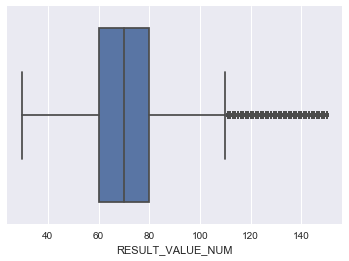

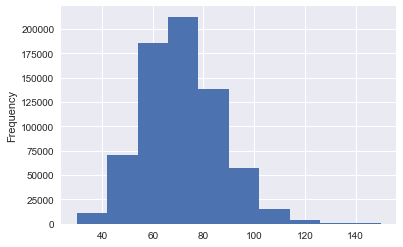

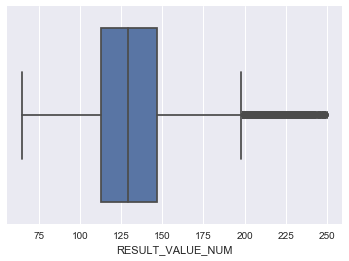

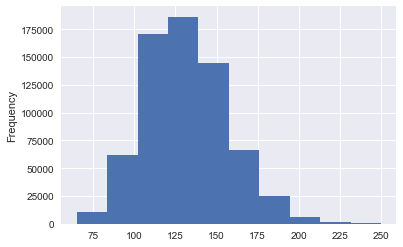

In [3]:
Diastolic_BP = pd.read_csv(root_direc+'/vital_sign/Diastolic_BP.csv')
plt.figure()
sns.boxplot(Diastolic_BP['RESULT_VALUE_NUM'])
plt.figure()
Diastolic_BP['RESULT_VALUE_NUM'].plot.hist()

# Next dig out the time different between first EVENT_DATE and
# first medication time

Diastolic_BP = Diastolic_BP.drop('PATIENT_ID', 1)
Diastolic_BP['EVENT_DATE'] = pd.to_datetime(Diastolic_BP['EVENT_DATE'])
# Merge the Diastolic_BP with patient level table
Diastolic_BP = pd.merge(Diastolic_BP,
                        pat_enc_final[['PATIENT_SK', 'ENCOUNTER_ID']],
                        how='inner', on='ENCOUNTER_ID')
# Group the Diastolic_BP by patient_sk
Diastolic_BP = Diastolic_BP.sort_values(by=['PATIENT_SK', 'EVENT_DATE'])
one_type_treatment_patsk = one_type_treatment_valid_tcs['PATIENT_SK'].unique()
valid_pat_sk_indc = np.in1d(
        one_type_treatment_patsk, Diastolic_BP['PATIENT_SK'].unique())
valid_pat_sk1 = one_type_treatment_patsk[valid_pat_sk_indc]
valid_pat_sk1.shape[0]

Systolic_BP = pd.read_csv(root_direc+'/vital_sign/Systolic_BP.csv')
plt.figure()
sns.boxplot(Systolic_BP['RESULT_VALUE_NUM'])
plt.figure()
Systolic_BP['RESULT_VALUE_NUM'].plot.hist()
Systolic_BP = Systolic_BP.drop('PATIENT_ID', 1)
Systolic_BP['EVENT_DATE'] = pd.to_datetime(Systolic_BP['EVENT_DATE'])
# Merge the Diastolic_BP with patient level table
Systolic_BP = pd.merge(Systolic_BP,
                       pat_enc_final[['PATIENT_SK', 'ENCOUNTER_ID']],
                       how='inner', on='ENCOUNTER_ID')
# Group the Systolic_BP by patient_sk
Systolic_BP = Systolic_BP.sort_values(by=['PATIENT_SK', 'EVENT_DATE'])
one_type_treatment_patsk = one_type_treatment_valid_tcs['PATIENT_SK'].unique()
valid_pat_sk_indc = np.in1d(
        one_type_treatment_patsk, Systolic_BP['PATIENT_SK'].unique())
valid_pat_sk2 = one_type_treatment_patsk[valid_pat_sk_indc]
valid_pat_sk2.shape[0]


In [4]:
concerned_pat = []
vaso = []
for patient_sk in valid_pat_sk2:
    sample_diasbp = Diastolic_BP[Diastolic_BP['PATIENT_SK'] == patient_sk]
    sample_med = one_type_treatment_valid_tcs[
        one_type_treatment_valid_tcs['PATIENT_SK'] == patient_sk]
    order_start_time = sample_med['MED_STARTED_DT_TM'].iloc[0]
    order_stop_time = sample_med['MED_STOPPED_DT_TM'].iloc[0]
    # Convert the resolution of time from second to hour
#    time_diasbp = time_diasbp.apply(total_seconds)/(60*60)
#    order_start_time = order_start_time.apply(total_seconds)/(60*60)
#    order_stop_time = order_stop_time.apply(total_seconds)/(60*60)
    duration_to_start = (order_start_time-sample_diasbp['EVENT_DATE']).apply(
            total_seconds)/(60*60)
    duration_to_stop = (sample_diasbp['EVENT_DATE']-order_stop_time).apply(
            total_seconds)/(60*60)
    if (max(duration_to_start)>0) & (max(duration_to_stop)>0):
            concerned_pat.append(patient_sk)
            vaso.append(sample_med['GENERIC_NAME'].iloc[0])

In [5]:
len(concerned_pat)

90

In [6]:
pd.Series(vaso).value_counts()

norepinephrine    47
phenylephrine     24
dopamine          19
dtype: int64

C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are 

C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


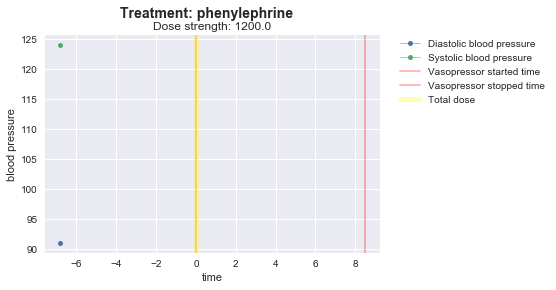

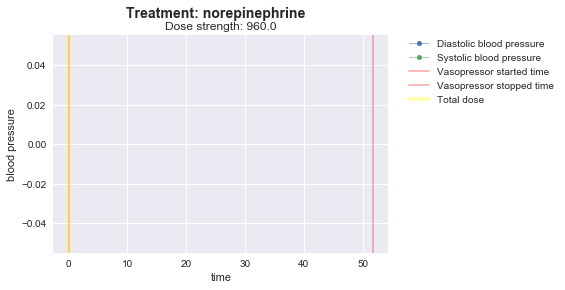

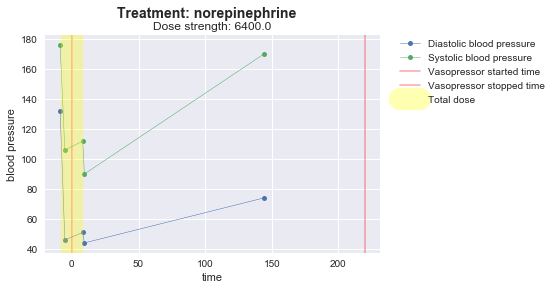

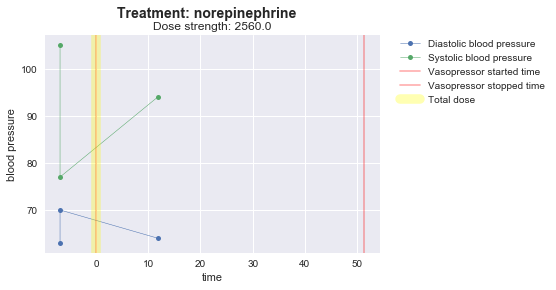

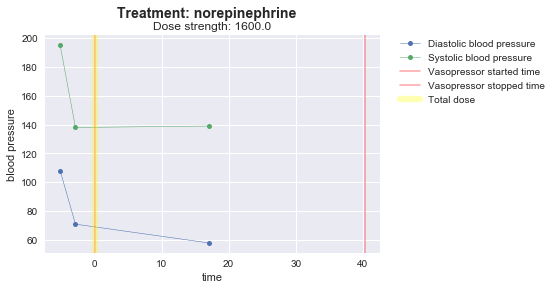

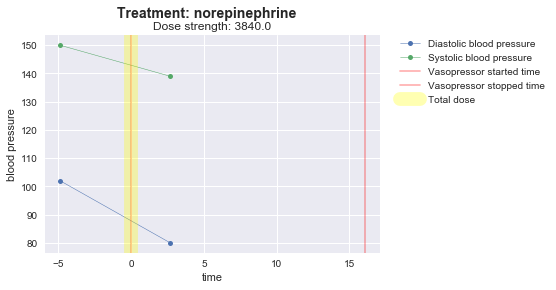

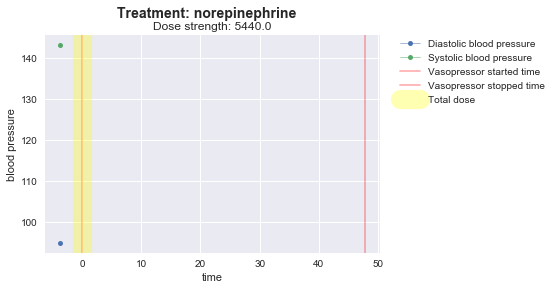

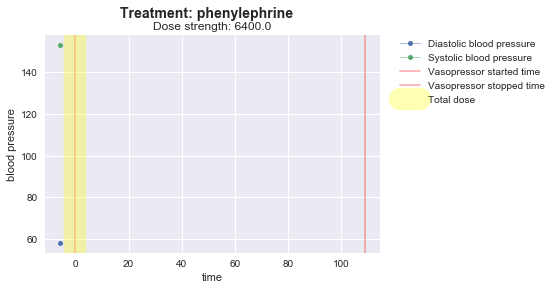

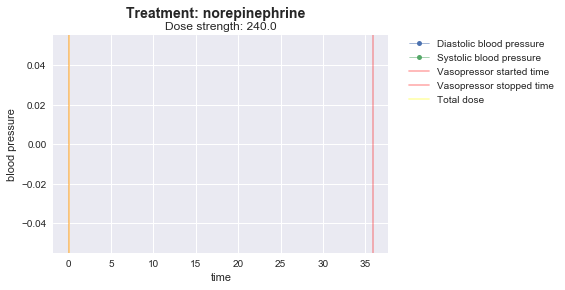

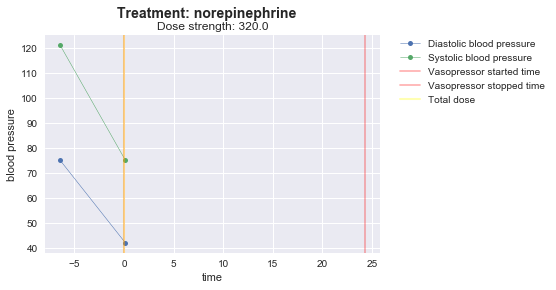

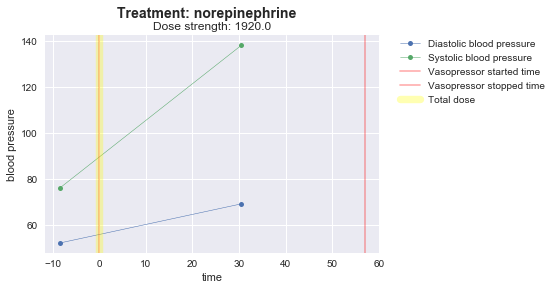

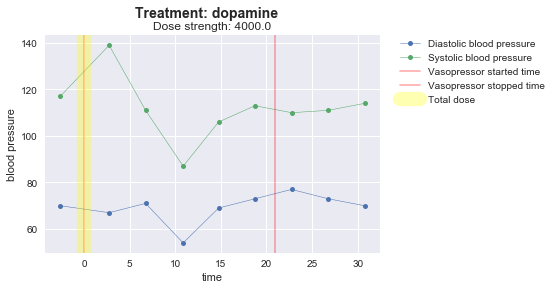

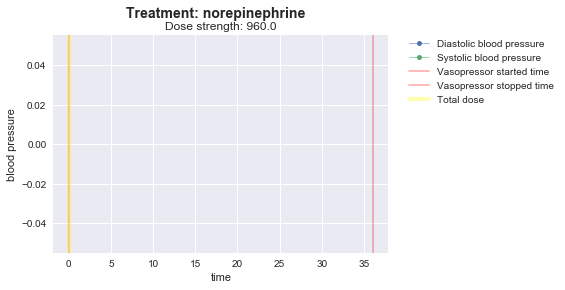

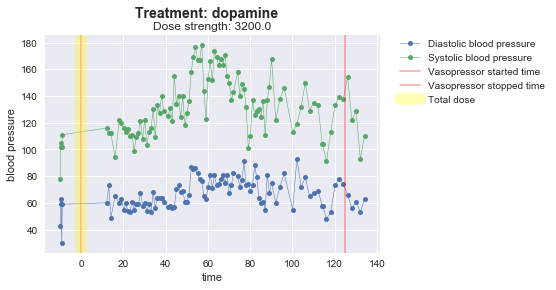

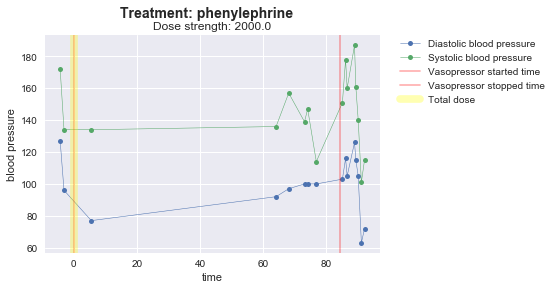

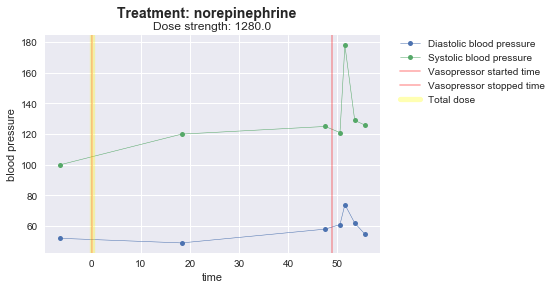

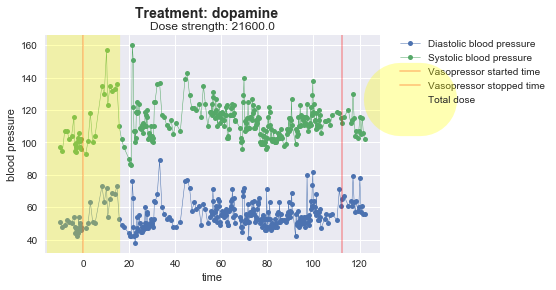

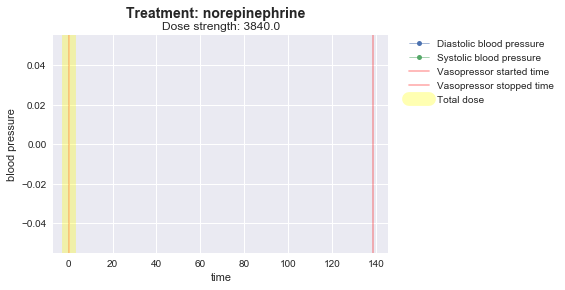

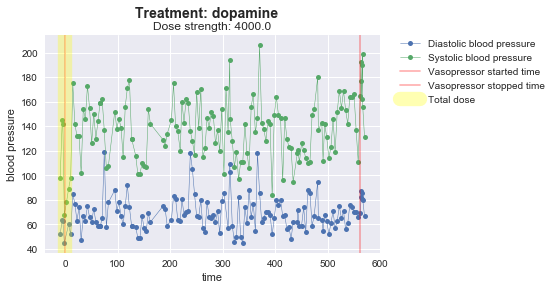

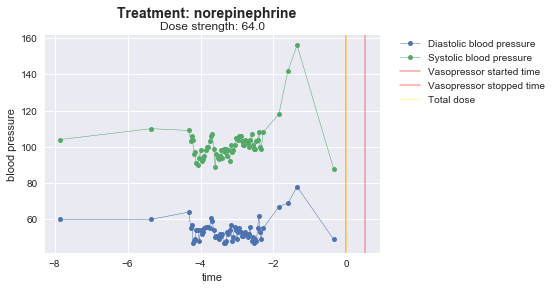

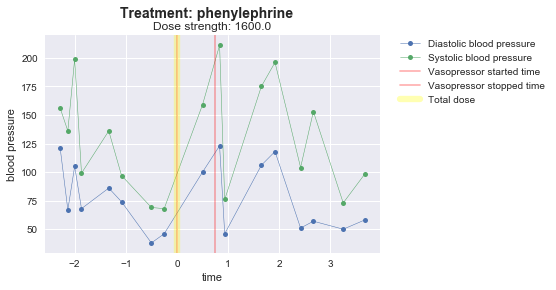

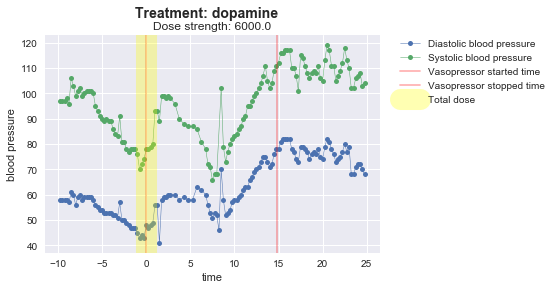

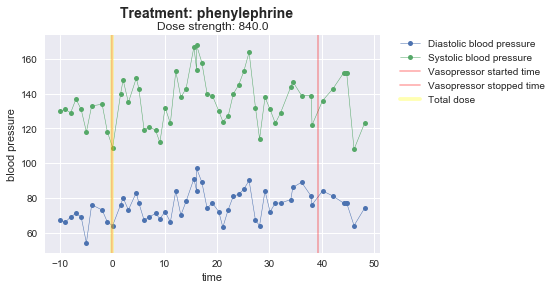

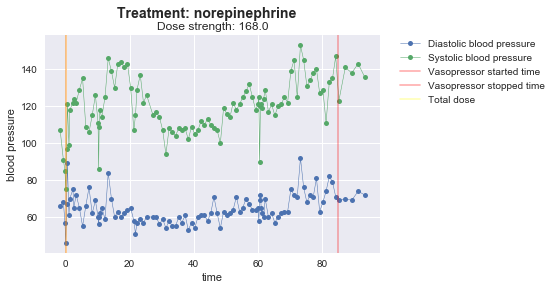

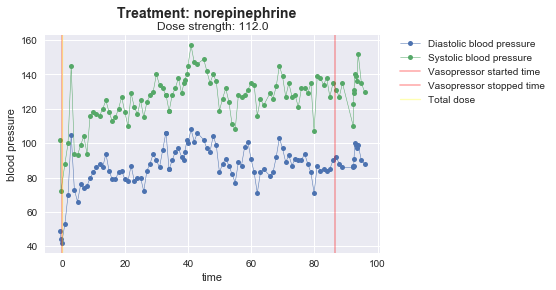

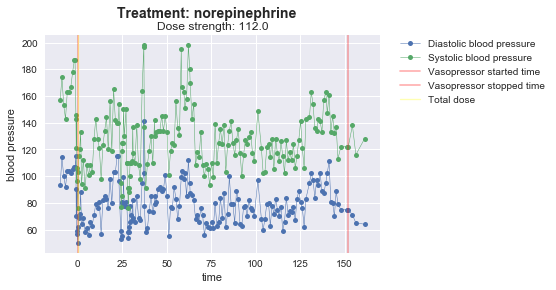

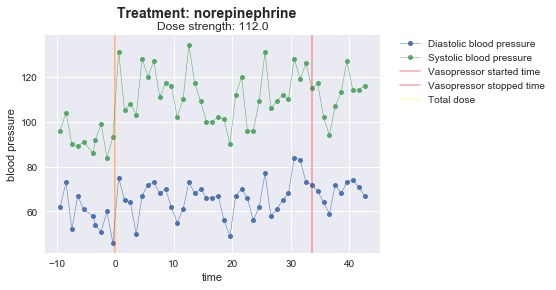

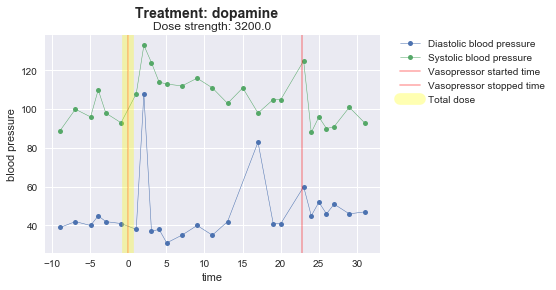

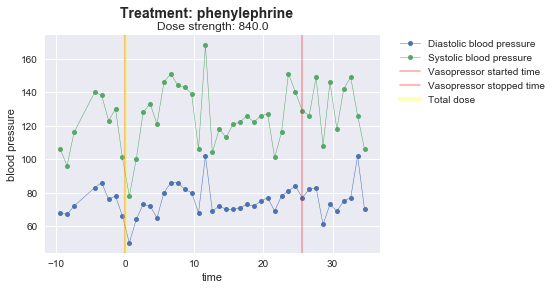

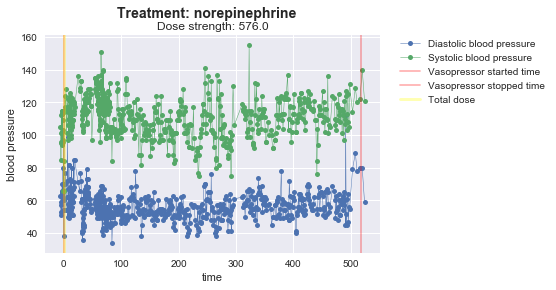

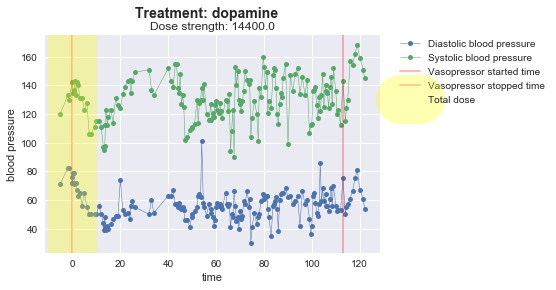

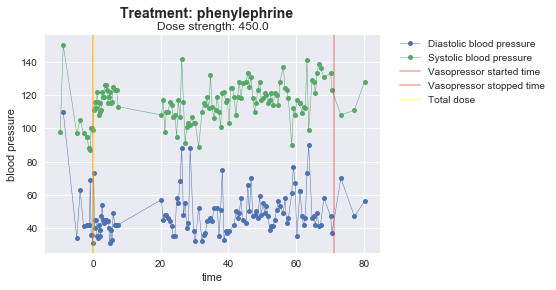

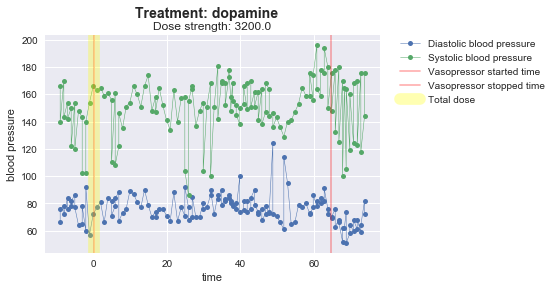

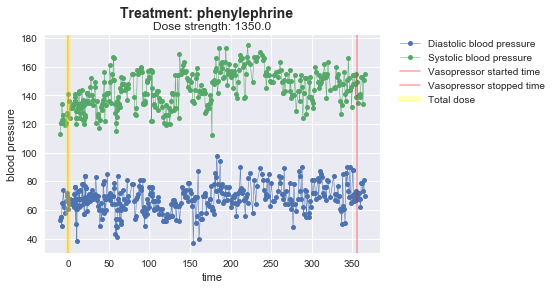

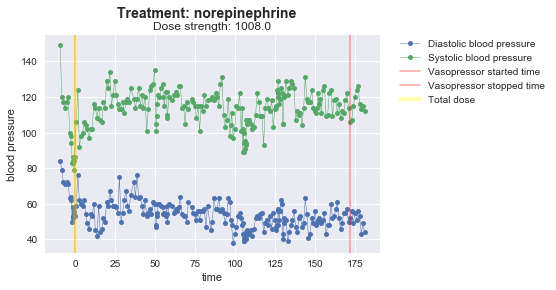

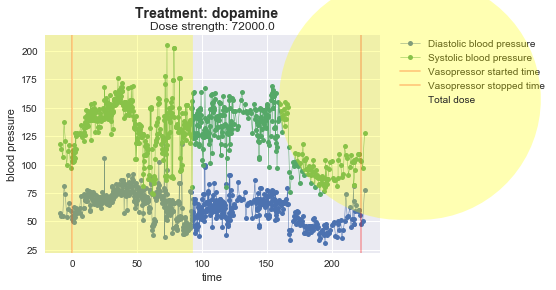

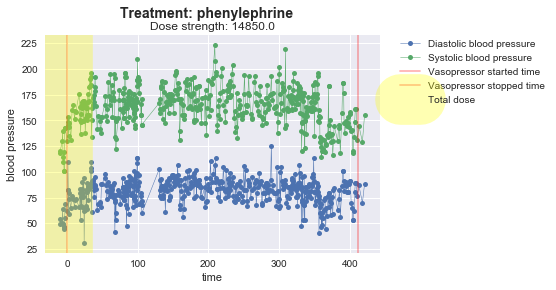

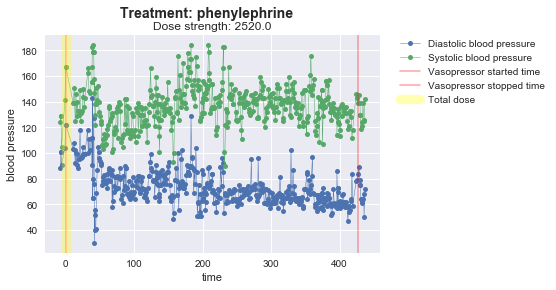

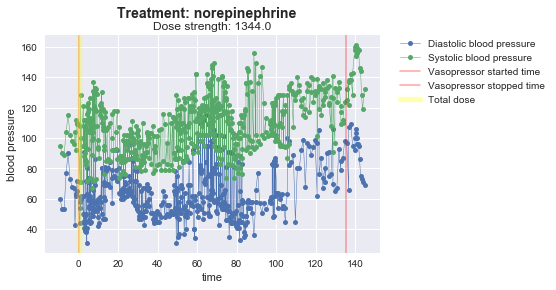

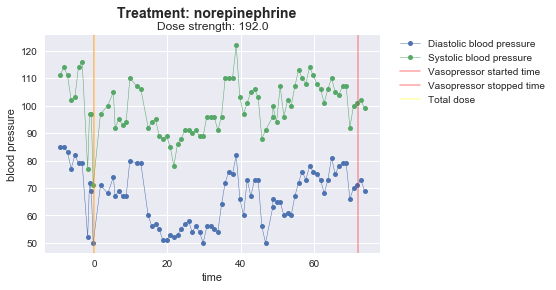

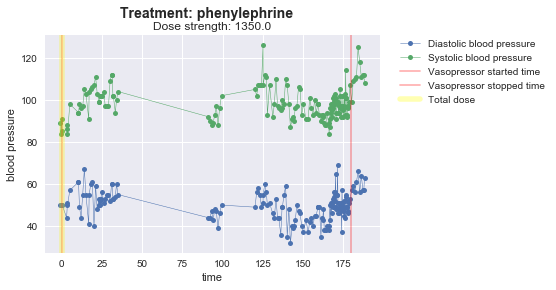

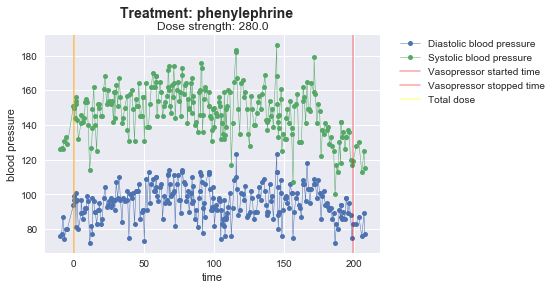

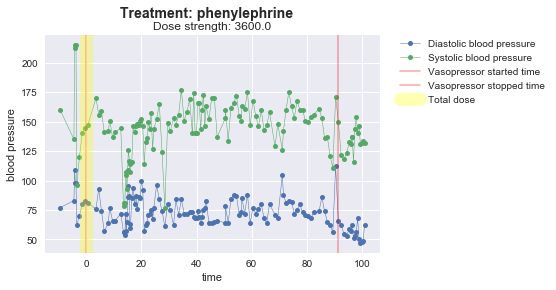

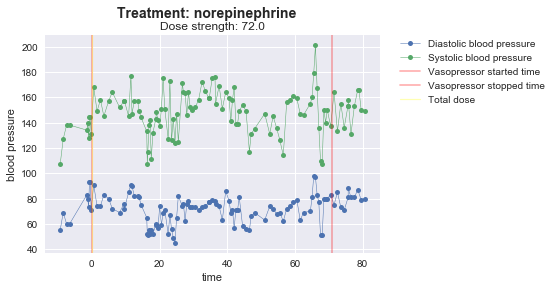

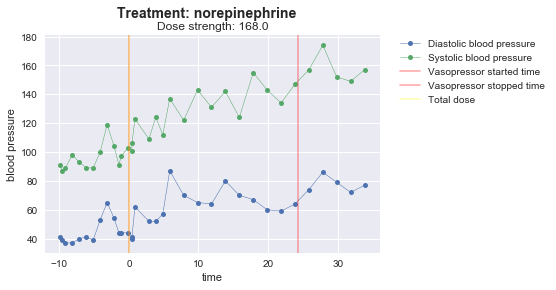

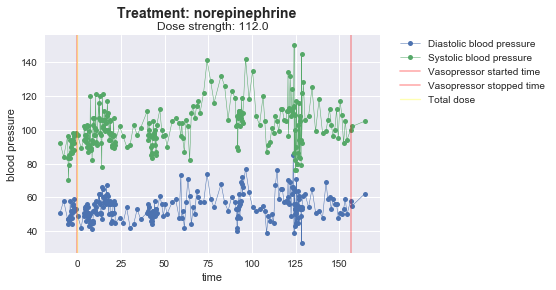

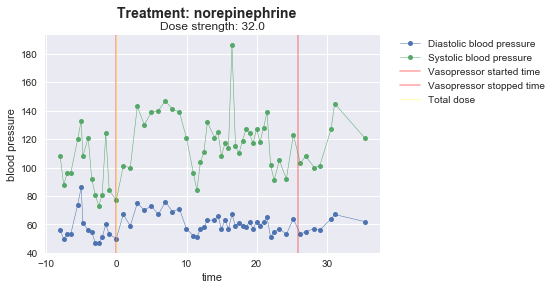

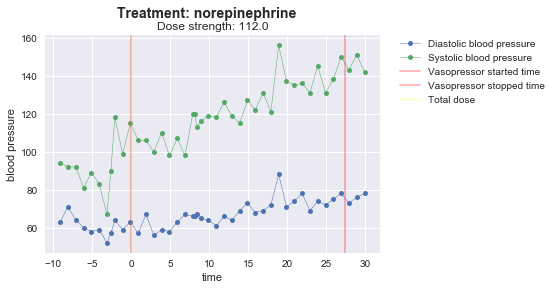

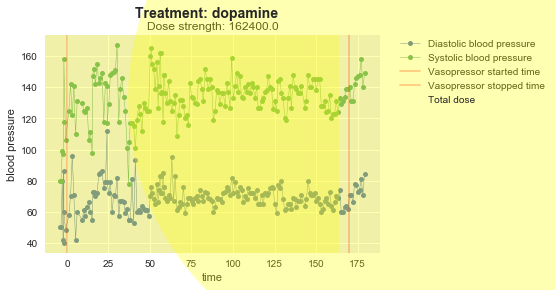

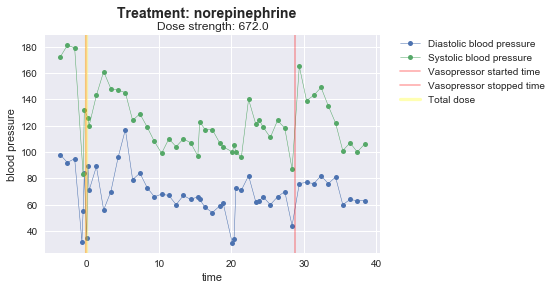

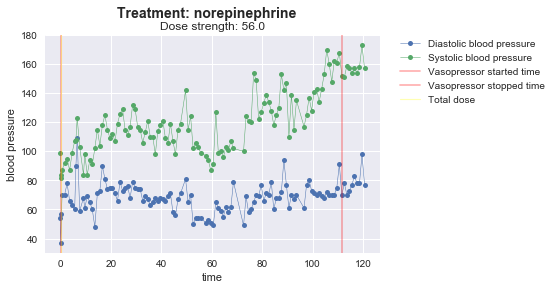

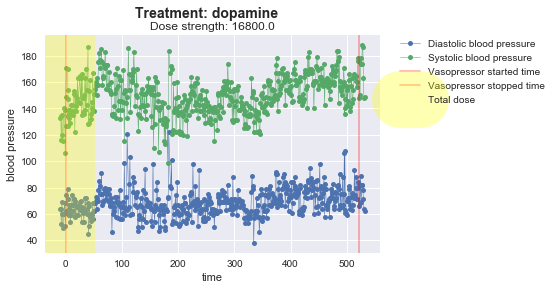

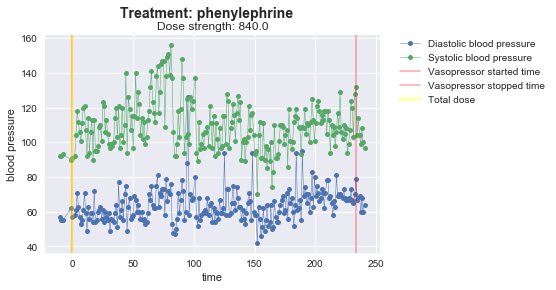

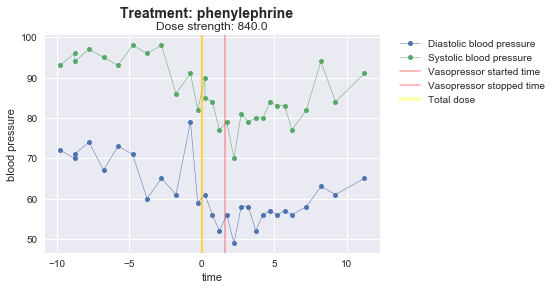

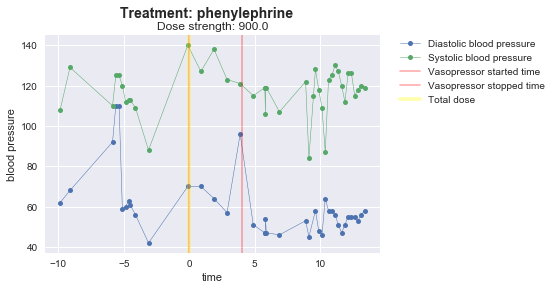

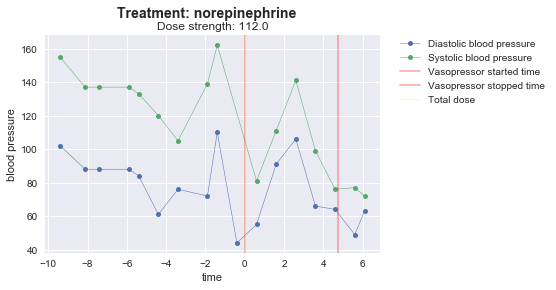

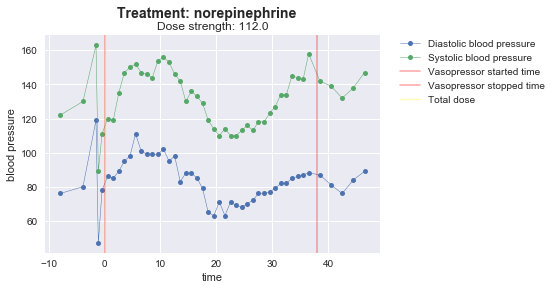

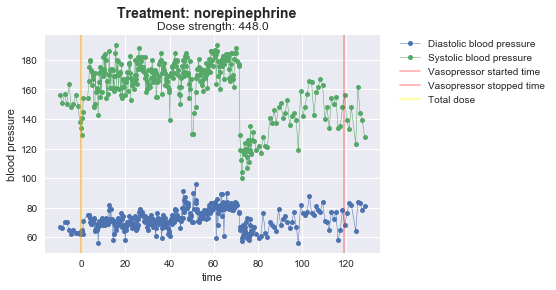

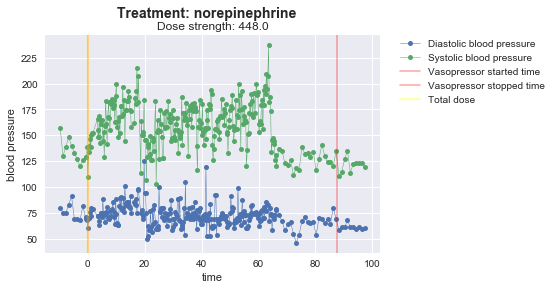

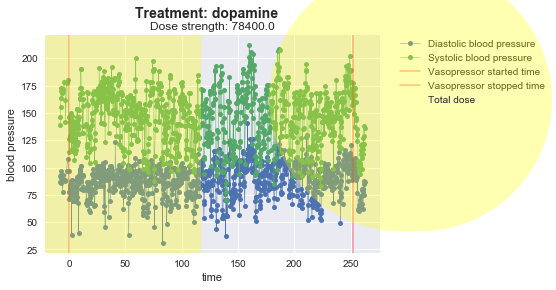

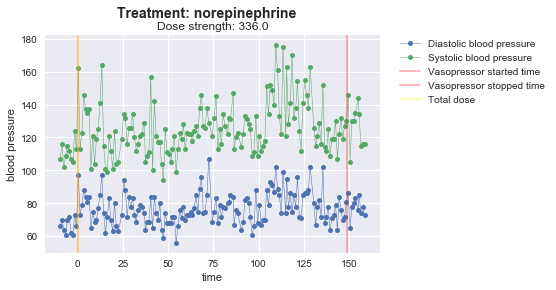

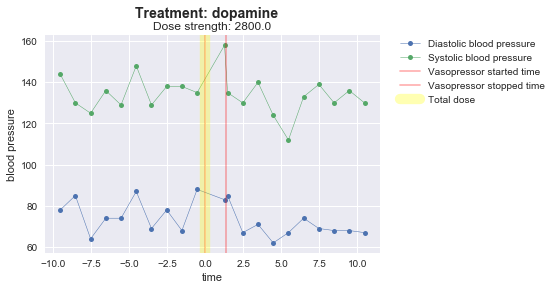

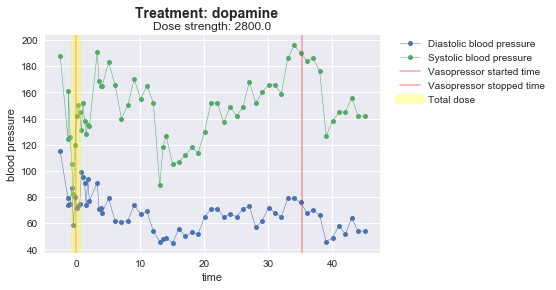

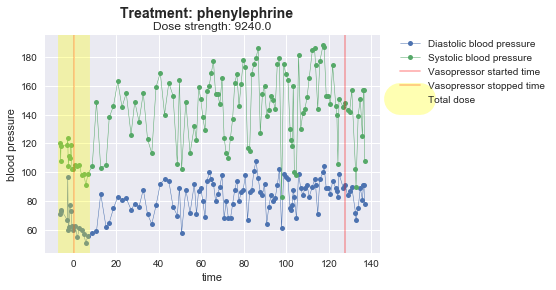

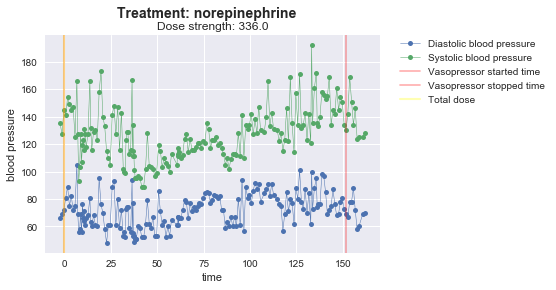

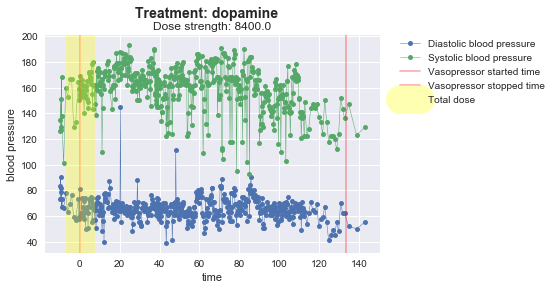

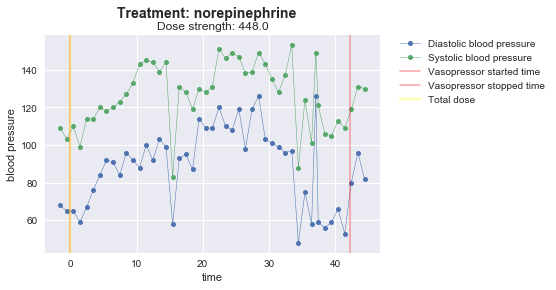

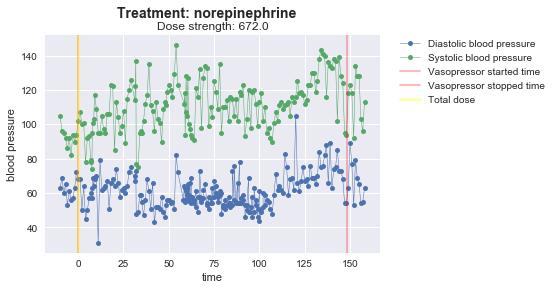

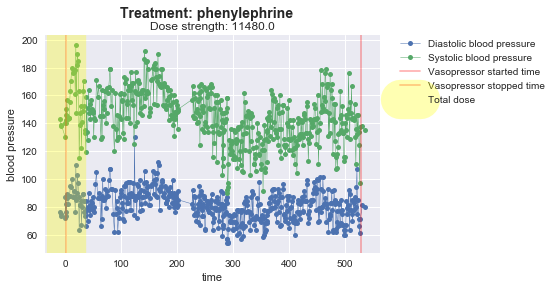

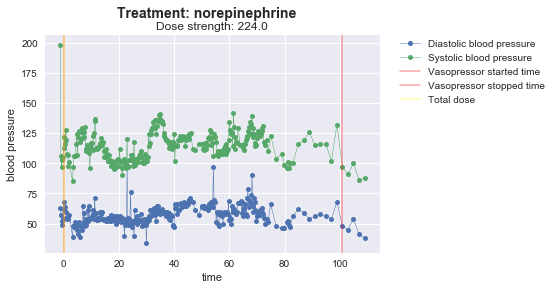

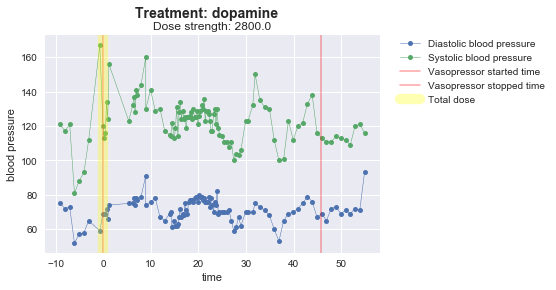

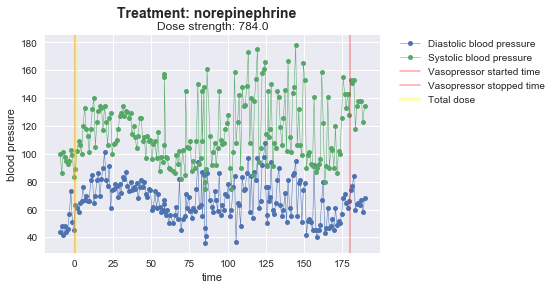

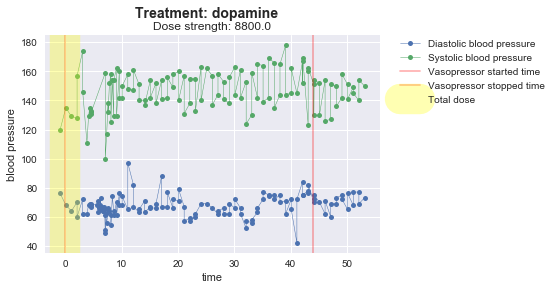

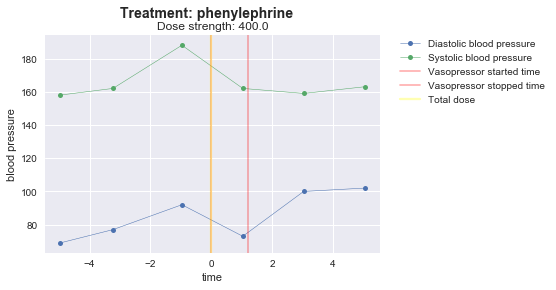

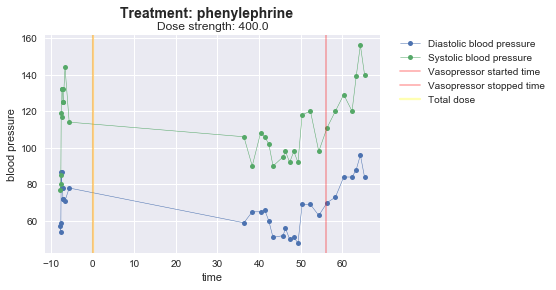

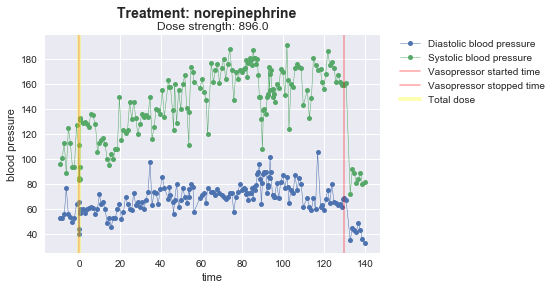

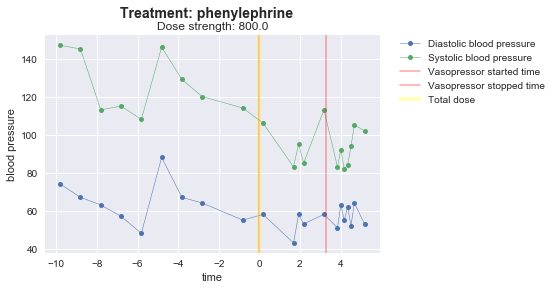

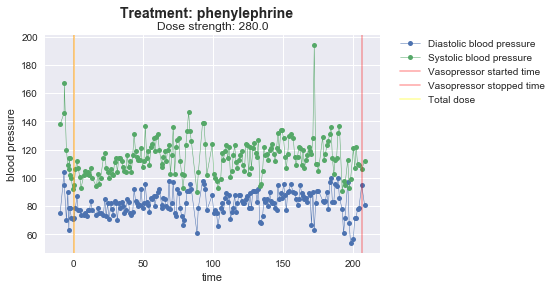

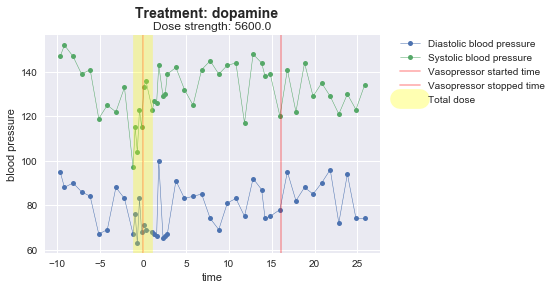

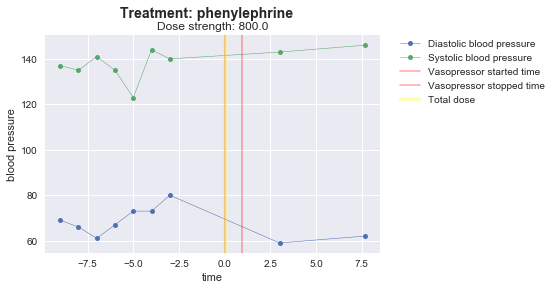

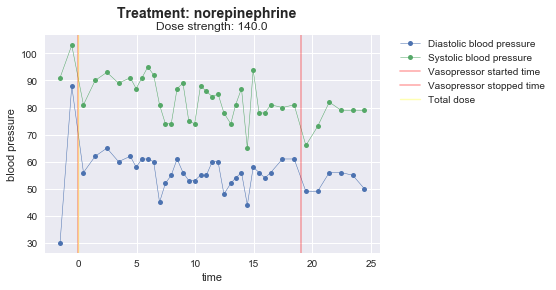

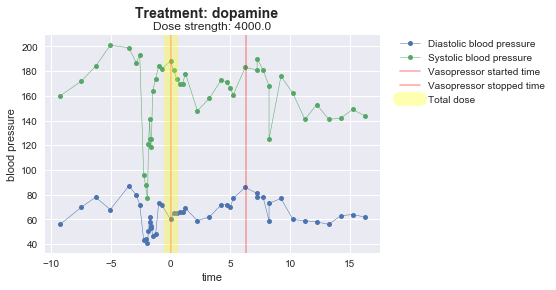

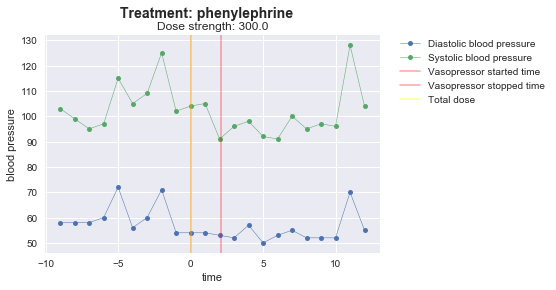

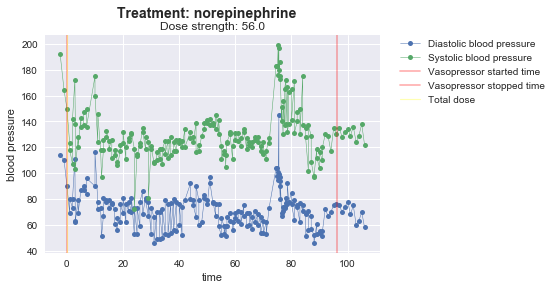

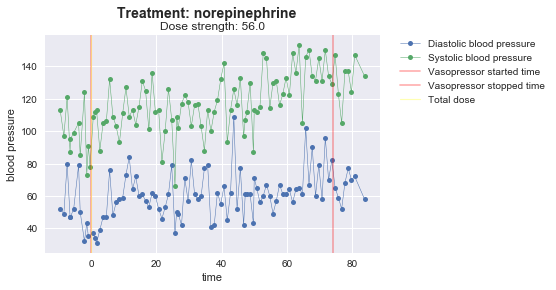

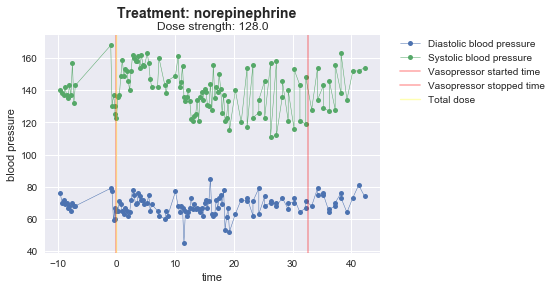

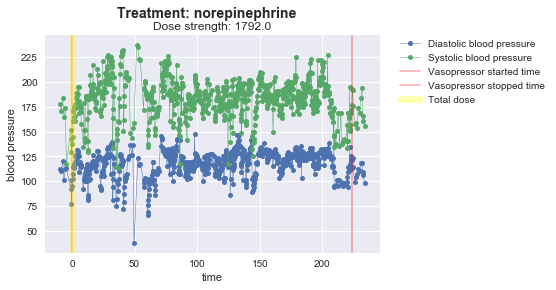

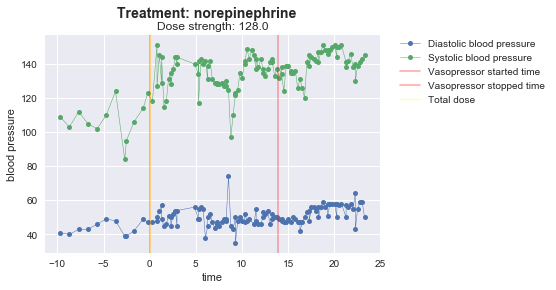

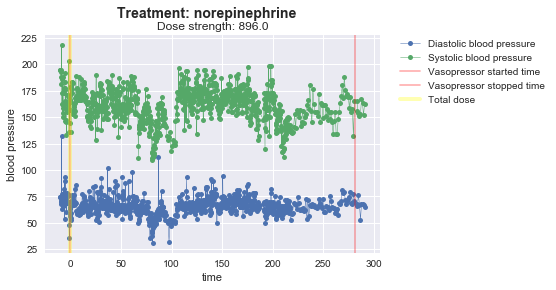

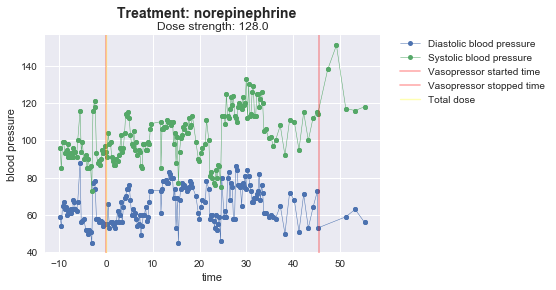

In [7]:
# Plot the figure
sample_patient_sk = np.random.choice(concerned_pat, 10)
# In order to visualize the total consumed strength, we specify the linewidth
# of vertical line by normalizing total consumed strength
array_tcs = np.array(one_type_treatment_valid_tcs['TOTAL_CONSUMED_STRENGTH'])
normalized_tcs = preprocessing.normalize([array_tcs])
one_type_treatment_valid_tcs['normalized_tcs'] = normalized_tcs.T
for patient_sk in concerned_pat:
    sample_diasbp = Diastolic_BP[Diastolic_BP['PATIENT_SK'] == patient_sk]
    sample_sysbp = Systolic_BP[Systolic_BP['PATIENT_SK'] == patient_sk]
    sample_med = one_type_treatment_valid_tcs[
        one_type_treatment_valid_tcs['PATIENT_SK'] == patient_sk]
    # Convert the time as the time difference from the first event time
    time_diasbp = sample_diasbp['EVENT_DATE'] - sample_med[
            'MED_STARTED_DT_TM'].iloc[0]
    time_sysbp = sample_sysbp['EVENT_DATE'] - sample_med[
            'MED_STARTED_DT_TM'].iloc[0]
    first_vaso_start = sample_med['MED_STARTED_DT_TM'].iloc[0] - sample_med[
            'MED_STARTED_DT_TM'].iloc[0]
    first_vaso_stop = sample_med['MED_STOPPED_DT_TM'].iloc[0] - sample_med[
            'MED_STARTED_DT_TM'].iloc[0]
    
    # Convert the resolution of time from second to hour
    time_diasbp = time_diasbp.apply(total_seconds)/(60*60)
    time_sysbp = time_sysbp.apply(total_seconds)/(60*60)
    first_vaso_start = total_seconds(first_vaso_start)/(60*60)
    first_vaso_stop = total_seconds(first_vaso_stop)/(60*60)
    # We care more about the time interval near the interval bewteen the startted
    # time and stopped time
    threshold = 10
    time_interval_interested = [first_vaso_start-threshold,
                                first_vaso_stop+threshold]
    time_interested_dias = pd.cut(time_diasbp, time_interval_interested)
    diasbp_interested = sample_diasbp[time_interested_dias.notnull()][
            'RESULT_VALUE_NUM']
    time_diasbp = time_diasbp[time_interested_dias.notnull()]
    time_interested_sys = pd.cut(time_sysbp, time_interval_interested)
    sysbp_interested = sample_sysbp[time_interested_sys.notnull()][
            'RESULT_VALUE_NUM']
    time_sysbp = time_sysbp[time_interested_sys.notnull()]
    
    fig, ax = plt.subplots()
    ax.plot(time_diasbp, diasbp_interested, "-o", markersize=5,
            linewidth=0.5, label="Diastolic blood pressure")
    ax.plot(time_sysbp, sysbp_interested, "-o", markersize=5,
            linewidth=0.5, label='Systolic blood pressure')
  
    ax.axvline(x=first_vaso_start, alpha=0.3, color="red",
                       label='Vasopressor started time')
    ax.axvline(x=first_vaso_stop, alpha=0.3, color="red",
               label='Vasopressor stopped time')
    ax.axvline(x=first_vaso_start, alpha=0.3, color="yellow",
                       linewidth=2000*sample_med['normalized_tcs'].iloc[0]+1,
                       label='Total dose')   
    
#        ax.text(time_med.iloc[i], ax.get_ylim()[0],
#                sample_med['GENERIC_NAME'].iloc[i], ha='center', color='red')
#        ax.text(time_med.iloc[i], ax.get_ylim()[1],
#                "dose: {}" .format(
#                      round(sample_med['TOTAL_CONSUMED_STRENGTH'].iloc[i], 2)),
#                ha='center', color='red')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    fig.suptitle('Treatment: {}'.format(sample_med['GENERIC_NAME'].iloc[0]),
                 fontsize=14, fontweight='bold')
    ax.set_title('Dose strength: {}'.format(
            sample_med['TOTAL_CONSUMED_STRENGTH'].iloc[0]))
    ax.set_xlabel('time')
    ax.set_ylabel('blood pressure')